In [1]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from pymorphy2 import MorphAnalyzer
from scipy.sparse.csr import csr_matrix

from typing import List, Union

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import AffinityPropagation, DBSCAN, KMeans, MeanShift
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, \
                            silhouette_score

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
punctuation += '«»—…“”*№–'
stopwords = set(stopwords.words('russian'))

In [4]:
class Lemmatizer:
    def __init__(self):
        self.morph = MorphAnalyzer()
        self.cache = {}
    
    def lemmatize(self, token):
        if token in self.cache:
            return self.cache[token]
        norm = self.morph.parse(token)[0].normal_form
        self.cache[token] = norm
        return norm

lemmatizer = Lemmatizer()

In [5]:
def dummy(x):
    return x

def normalize(text: str) -> List[str]:
    output = []
    for token in word_tokenize(text.lower()):
        token = token.strip(punctuation)
        if not token:
            continue
            
        lemma = lemmatizer.lemmatize(token)
        if lemma in stopwords:
            continue
            
        output.append(lemma)
    
    return output

In [6]:
data = pd.read_csv('data.csv')
data = data[['category_name', 'title']]
pd.set_option('display.max_rows', 500)

In [7]:
data.shape

(254219, 2)

In [8]:
def print_clustering_metrics(X: Union[np.ndarray, csr_matrix], y: List[str], labels: List[str]) -> None:
    print('Silhouette Coefficient: %0.3f'
          % metrics.silhouette_score(X, labels))
    
    print('Homogeneity: %0.3f' % metrics.homogeneity_score(y, labels))
    print('Completeness: %0.3f' % metrics.completeness_score(y, labels))
    print('V-measure: %0.3f' % metrics.v_measure_score(y, labels))
    print('Adjusted Rand Index: %0.3f'
          % metrics.adjusted_rand_score(y, labels))
    print('Adjusted Mutual Information: %0.3f'
          % metrics.adjusted_mutual_info_score(y, labels))

# CountVectorizer vs. TfidfVectorizer

In [9]:
sample = data.sample(frac=0.01)

In [10]:
cv_word = CountVectorizer(max_features=1000, preprocessor=normalize, tokenizer=dummy,
                          min_df=5, max_df=0.75, ngram_range=(1, 3))
X_cv_word = cv_word.fit_transform(sample['title'])

cv_char = CountVectorizer(max_features=1000, preprocessor=lambda x: ' '.join(normalize(x)),
                          analyzer='char_wb', min_df=10, max_df=0.75, ngram_range=(3, 5))
X_cv_char = cv_char.fit_transform(sample['title'])

tfidf_word = TfidfVectorizer(max_features=1000, preprocessor=normalize, tokenizer=dummy,
                             min_df=5, max_df=0.75, ngram_range=(1, 3))
X_tfidf_word = tfidf_word.fit_transform(sample['title'])

tfidf_char = TfidfVectorizer(max_features=1000, preprocessor=lambda x: ' '.join(normalize(x)),
                             analyzer='char_wb', min_df=10, max_df=0.75, ngram_range=(3, 5))
X_tfidf_char = tfidf_char.fit_transform(sample['title'])

y = sample['category_name']

## AffinityPropagation

In [11]:
cluster = AffinityPropagation(damping=0.75, preference=-5, max_iter=1000, verbose=2)

In [12]:
print_clustering_metrics(X_cv_word, y, cluster.fit(X_cv_word).labels_)

Converged after 176 iterations.
Silhouette Coefficient: 0.412
Homogeneity: 0.462
Completeness: 0.395
V-measure: 0.426
Adjusted Rand Index: -0.016
Adjusted Mutual Information: 0.269


In [13]:
print_clustering_metrics(X_cv_char, y, cluster.fit(X_cv_char).labels_)

Converged after 189 iterations.
Silhouette Coefficient: 0.255
Homogeneity: 0.844
Completeness: 0.399
V-measure: 0.542
Adjusted Rand Index: 0.021
Adjusted Mutual Information: 0.129


In [14]:
print_clustering_metrics(X_tfidf_word, y, cluster.fit(X_tfidf_word).labels_)

Converged after 235 iterations.
Silhouette Coefficient: 0.393
Homogeneity: 0.378
Completeness: 0.386
V-measure: 0.382
Adjusted Rand Index: -0.027
Adjusted Mutual Information: 0.270


In [15]:
print_clustering_metrics(X_tfidf_char, y, cluster.fit(X_tfidf_char).labels_)

Converged after 247 iterations.
Silhouette Coefficient: 0.216
Homogeneity: 0.444
Completeness: 0.405
V-measure: 0.424
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.318


Over several attempts to calculate these score, it became clear that winners in each "category" (the metric we consider) are different from attempt to attempt. The algorithm is simply too random for our sparse data.

# SVD vs. NMF

In [16]:
cv = CountVectorizer(preprocessor=normalize, tokenizer=dummy,
                     min_df=5, max_df=0.75, ngram_range=(1, 3))
X_cv = cv_word.fit_transform(sample['title'])

In [17]:
svd = TruncatedSVD(50)
X_svd = svd.fit_transform(X_cv)

In [18]:
nmf = NMF(50)
X_nmf = nmf.fit_transform(X_cv)

## DBSCAN

In [19]:
cluster = DBSCAN(min_samples=10, eps=0.3) 

In [20]:
print_clustering_metrics(X_svd, y, cluster.fit(X_svd).labels_)

Silhouette Coefficient: 0.491
Homogeneity: 0.197
Completeness: 0.323
V-measure: 0.245
Adjusted Rand Index: -0.012
Adjusted Mutual Information: 0.146


In [21]:
print_clustering_metrics(X_nmf, y, cluster.fit(X_nmf).labels_)

Silhouette Coefficient: 0.462
Homogeneity: 0.103
Completeness: 0.317
V-measure: 0.155
Adjusted Rand Index: -0.013
Adjusted Mutual Information: 0.075


## KMeans

In [22]:
cluster = KMeans(n_clusters=47)

In [23]:
print_clustering_metrics(X_svd, y, cluster.fit(X_svd).labels_)

Silhouette Coefficient: 0.646
Homogeneity: 0.289
Completeness: 0.405
V-measure: 0.337
Adjusted Rand Index: -0.022
Adjusted Mutual Information: 0.223


In [24]:
print_clustering_metrics(X_nmf, y, cluster.fit(X_nmf).labels_)

Silhouette Coefficient: 0.675
Homogeneity: 0.290
Completeness: 0.389
V-measure: 0.332
Adjusted Rand Index: -0.027
Adjusted Mutual Information: 0.221


## MeanShift

In [25]:
cluster = MeanShift(cluster_all=False, bandwidth=0.5)

In [26]:
print_clustering_metrics(X_svd, y, cluster.fit(X_svd).labels_)

Silhouette Coefficient: 0.723
Homogeneity: 0.362
Completeness: 0.367
V-measure: 0.364
Adjusted Rand Index: -0.026
Adjusted Mutual Information: 0.202


In [27]:
print_clustering_metrics(X_nmf, y, cluster.fit(X_nmf).labels_)

Silhouette Coefficient: 0.534
Homogeneity: 0.058
Completeness: 0.360
V-measure: 0.099
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.037


Overall, it's clear that SVD is slightly better to decompose BoW-matrices for clustering.

# Data outliers

## DBSCAN

In [28]:
cluster = DBSCAN(min_samples=10, eps=0.3)
cluster.fit(X_svd)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None)

In [29]:
sample['cluster'] = cluster.labels_

In [30]:
sample[sample.cluster == -1].head(10)

,category_name,title,cluster
140930,Детская одежда и обувь,Брюки на девочку,-1
172885,Гаражи и машиноместа,"Гараж, 30 м²",-1
238557,"Одежда, обувь, аксессуары",Балетки 38 размер,-1
153395,Детская одежда и обувь,Одежда для мальчика,-1
99121,Детская одежда и обувь,Резиновые сапоги Капика. Размер 25,-1
227220,Земельные участки,Участок 10 сот. (ИЖС),-1
170521,Телефоны,iPhone 5s 16gb,-1
83539,"Дома, дачи, коттеджи",Дача 21 м² на участке 4 сот.,-1
119366,Спорт и отдых,Продаю роликовые коньки размер 35-38,-1
78629,Товары для компьютера,Монитор с IPS матрицей LG 32MP58HQ-P 2016 года,-1


It seems like this particular algorithm doesn't work with numbers very well, it tends to mark sentences containing numbers as outliers.

## MeanShift

In [31]:
cluster = MeanShift(cluster_all=False, bandwidth=2)
cluster.fit(X_svd)

MeanShift(bandwidth=2, bin_seeding=False, cluster_all=False, min_bin_freq=1,
     n_jobs=None, seeds=None)

In [32]:
sample['cluster'] = cluster.labels_

In [33]:
sample[sample.cluster == -1].head(10)

,category_name,title,cluster
225358,Квартиры,"3-к квартира, 59 м², 9/13 эт.",-1
227220,Земельные участки,Участок 10 сот. (ИЖС),-1
83539,"Дома, дачи, коттеджи",Дача 21 м² на участке 4 сот.,-1
39540,Квартиры,"1-к квартира, 36.8 м², 3/9 эт.",-1
136663,Квартиры,"2-к квартира, 51 м², 4/12 эт.",-1
126081,Комнаты,"Комната 12 м² в 1-к, 5/5 эт.",-1
18454,"Дома, дачи, коттеджи",Дом 165 м² на участке 4 сот.,-1
119270,"Дома, дачи, коттеджи",Дом 90 м² на участке 7 сот.,-1
80626,Автомобили,"ВАЗ 2114 Samara, 2004",-1
94113,Коммерческая недвижимость,"Помещение свободного назначения, 85.9 м²",-1


Here, the picture is similar. It is clear that all these "outliers" contain numbers, square meters, and specific contractions.

# Optimal number of clusters ("shoulder" method)

In [34]:
cluster_nums = [5, 10] + list(range(50, 1001, 50))

scores = []
for i in tqdm(cluster_nums):
    cluster = KMeans(n_clusters=i)
    cluster.fit(X_svd)
    scores.append(metrics.silhouette_score(X_svd, cluster.labels_))

100%|██████████| 22/22 [00:55<00:00,  4.41s/it]


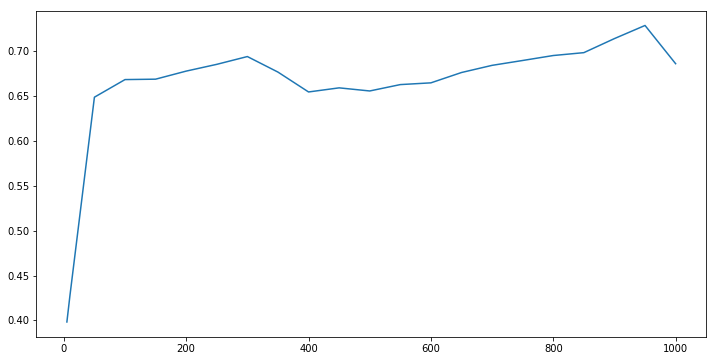

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(cluster_nums, scores)
plt.show()

Interestingly enough, the shoulder is clearly visible. 50-100 tokens is the optimal value.